<a href="https://colab.research.google.com/github/Tommy-Gozali/my_project/blob/main/Profitability_of_PV_Battery_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyomo
!pip install -q condacolab
import condacolab
condacolab.install()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:22
🔁 Restarting kernel...


In [ ]:
!conda --version

In [ ]:
!conda install -c conda-forge glpk

Solving environment: - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - glpk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-23.1.0               |   py39hf3d152e_0         906 KB  conda-forge
    glpk-5.0                   |       h445213a_0        1023 KB  conda-forge
    gmp-6.2.1                  |       h58526e2_0         806 KB  conda-forge
    openssl-3.1.0              |       h0b41bf4_0         2.5 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.2 MB

The following NEW packages will be INSTALLED:

  glpk               conda-forge/linux-64::glpk-5.0-h445213a_0 
  gmp                conda-forge/linux-64::gmp-6.2.1-h58526e2_0 

The following packages will be UPDATED:

  conda               

In [ ]:
from pyomo.opt import SolverFactory
from google.colab import drive

import pyomo.environ as pyo
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glpk

In [ ]:
data                                = pd.read_csv('/content/drive/MyDrive/data_science_portfolio/profitability_PV_battery_system/energy_demand.csv')
storageCapacity                     = 6863.45 # in kWh
maximum_discharge_charge_power_rate = 0.6 #maximum charging and discharging power
storagePower                        = maximum_discharge_charge_power_rate*storageCapacity #in kW
initialSOC                          = 0.0 #initial State of Charge (ratio from capacity)
chargingEfficiency                  = 0.94
dischargingEfficiency               = 0.94
delta_t                             = 1 #in h
pv_max_power                        = 5417.185 #maximum pv power production in kW
p_supply                            = 0.24 #in €/ kWh
p_fit                               = 0.0778 # in €/kWh
lambdas                             = 0.01
ohm                                 = 4118070 #in €
PV_cap                              = 6863.45 #kW

In [ ]:


''' FIRST OBJECTIVE FUNCTION '''

def mincost(data):
  model = pyo.ConcreteModel()

  model.i = pyo.RangeSet(0, len(data)-1)

  model.E_supply        = pyo.Var(model.i,domain=pyo.NonNegativeReals) #Energy supplied from the grid (kWh)
  model.E_feedin        = pyo.Var(model.i,domain=pyo.NonNegativeReals) #Energy fed to the grid (kWh)

  model.batteryCapacity = pyo.Var(domain=pyo.NonNegativeReals)
  model.SOC             = pyo.Var(model.i, domain=pyo.NonNegativeReals,bounds = (0.0, storageCapacity))
  model.charge          = pyo.Var(model.i, domain=pyo.NonNegativeReals)
  model.discharge       = pyo.Var(model.i, domain=pyo.NonNegativeReals)
  model.pv_feedin_max   = pyo.Var(model.i, domain=pyo.NonNegativeReals,bounds = (0.0, pv_max_power))

  model.x               = pyo.Var(model.i, domain=pyo.Binary) #binary variables to make sure the E_supply and E_feedin do not happen at the same time
  model.y               = pyo.Var(model.i, domain=pyo.Binary) #binary variables to make sure the E_supply and E_feedin do not happen at the same time

  model.objective1      = pyo.Var(model.i,domain=pyo.NonNegativeReals)
  model.objective2      = pyo.Var(model.i,domain=pyo.NonNegativeReals)

  def SOC_rule(model, i): #SOC constraints
    if i == 0:
        return model.SOC[i] == initialSOC * (storageCapacity)+ model.charge[i] * chargingEfficiency - model.discharge[i] / dischargingEfficiency
    else:
        return model.SOC[i] == model.SOC[i-1] + model.charge[i] * chargingEfficiency - model.discharge[i] / dischargingEfficiency

  def batteryCapacity_rule(model, i):
    return model.SOC[i] <= storageCapacity

  def charge_rule(model,i):
    return model.charge[i]/delta_t <= storagePower

  def charge_rule2(model,i):
    return model.charge[i]*(data['Energy Demand (kWh)'].iloc[i]-data['Energy PV (kWh)'].iloc[i]) <= 0

  def discharge_rule(model,i):
    return model.discharge[i]/delta_t <= storagePower

  def discharge_rule2(model,i):
    return model.discharge[i]*(data['Energy PV (kWh)'].iloc[i]-data['Energy Demand (kWh)'].iloc[i]) <= 0

  def feedin_rule(model,i):
    return model.E_feedin[i]/delta_t <= model.pv_feedin_max[i]

  def energyBalance_rule(model, i): #Energy balance constraint
    return model.E_supply[i] - model.E_feedin[i] == data['Energy Demand (kWh)'].iloc[i] - data['Energy PV (kWh)'].iloc[i] + model.charge[i] - model.discharge[i]

  def xy_rule(model,i):
    return model.x[i]+model.y[i] <=1

  def objective1_rule(model,i):
    return model.objective1[i] == model.E_supply[i]*p_supply - model.E_feedin[i]*p_fit

  def objective2_rule(model,i):
    return model.objective2[i] == lambdas*((model.E_supply[i]*p_supply - model.E_feedin[i]*p_fit)/ohm)+(1-lambdas)*(p_feedinmax/PV_cap)

  def only_feed_rule(model,i):
    return model.E_feedin[i]*((data['Energy Demand (kWh)'].iloc[i]+model.charge[i])-(data['Energy PV (kWh)'].iloc[i]+model.discharge[i])) <= 0

  def only_sup_rule(model,i):
    return model.E_supply[i]*((data['Energy PV (kWh)'].iloc[i]+model.discharge[i])-(data['Energy Demand (kWh)'].iloc[i]+model.charge[i])) <= 0

  model.energyBalance_rule   = pyo.Constraint(model.i, rule = energyBalance_rule)
  model.SOC_rule             = pyo.Constraint(model.i, rule = SOC_rule)
  model.batteryCapacity_rule = pyo.Constraint(model.i, rule = batteryCapacity_rule)
  model.chargerule           = pyo.Constraint(model.i, rule = charge_rule)
  model.dischargerule        = pyo.Constraint(model.i, rule = discharge_rule)
  model.feedinrule           = pyo.Constraint(model.i, rule = feedin_rule)
  model.objective1_rule      = pyo.Constraint(model.i, rule = objective1_rule)

  def ObjRule(model):
    return pyo.summation(model.objective1)    # first obj function

  model.obj = pyo.Objective(rule = ObjRule, sense=pyo.minimize)

  opt = SolverFactory("glpk")

  opt.solve(model)
  return model

In [ ]:
def get_values(model):
  E_supp_1 = []
  E_feedinn_1 = []
  Costt_1 = []
  E_charge_1 = []
  E_discharge_1 = []
  SOCC_1 = []
  for i in range(len(data)):
    E_supp_1.append(model.E_supply[i].value)
    E_feedinn_1.append(model.E_feedin[i].value)
    Costt_1.append(model.objective1[i].value)
    #Costt_peak.append(model.objective2[i].value)
    E_charge_1.append(model.charge[i].value)
    E_discharge_1.append(model.discharge[i].value)
    SOCC_1.append(model.SOC[i].value)



  return E_supp_1, E_feedinn_1, Costt_1, E_charge_1, E_discharge_1, SOCC_1

model = mincost(data)


In [ ]:
model

Result of the first objective function:
Cost after optimization:  2492760.9645347497 €
SCR (First Objective Function) = 85.5284776556678 %
SSR (First Objective Function) = 38.14388593570903 %


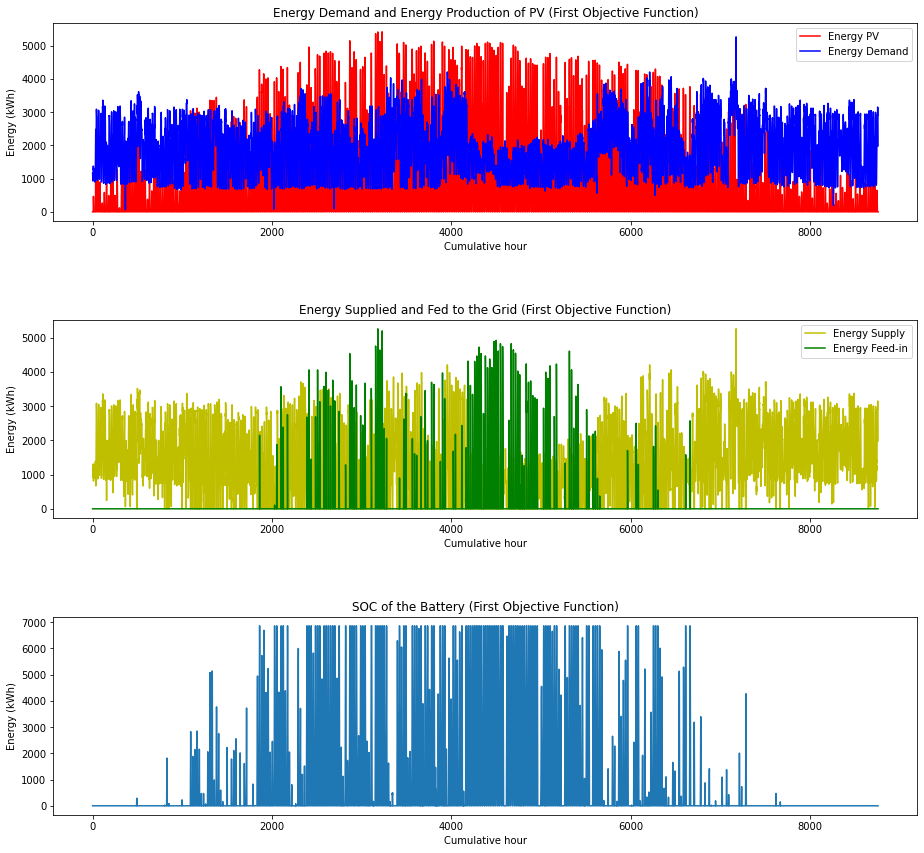

In [ ]:
E_supp_1, E_feedinn_1, Costt_1,E_charge_1,E_discharge_1,SOCC_1= get_values(model)
print('Result of the first objective function:')
print('Cost after optimization: ', sum(Costt_1) , '€')



#SCR and SSR calculation
df_1 = pd.DataFrame()
df_1['E_sup']       = E_supp_1
df_1['E_feedin']    = E_feedinn_1
df_1['E_PV']        = data['Energy PV (kWh)']
df_1['E_charge']    = E_charge_1
df_1['E_discharge'] = E_discharge_1
df_1['E_demand']    = data['Energy Demand (kWh)']
df_1['SOC']         = SOCC_1

df_1['SCR'] = df_1['E_PV'] - df_1['E_feedin'] - (1-chargingEfficiency)*df_1['E_charge']-(1-(1/dischargingEfficiency))*df_1['E_discharge']

SCR = (df_1['SCR'].sum()/df_1['E_PV'].sum())*100
SSR = (df_1['SCR'].sum()/df_1['E_demand'].sum())*100
print('SCR (First Objective Function) =',SCR,'%')
print('SSR (First Objective Function) =',SSR,'%')


t = []
for i in range(0,len(data)):
    t.append(i)

plt.figure(1, figsize=(12, 10))
plt.subplot(3,1,1)
plt.plot(t,data['Energy PV (kWh)'],'r',label = 'Energy PV')
plt.plot(t,data['Energy Demand (kWh)'],'b',label = 'Energy Demand')
plt.ylabel('Energy (kWh)')
plt.title('Energy Demand and Energy Production of PV (First Objective Function)')
plt.xlabel('Cumulative hour')
plt.legend()


plt.subplot(3,1,2)
plt.plot(t,E_supp_1,'y',label = 'Energy Supply')
plt.plot(t,E_feedinn_1,'g',label = 'Energy Feed-in')
plt.ylabel('Energy (kWh)')
plt.title('Energy Supplied and Fed to the Grid (First Objective Function)')
plt.xlabel('Cumulative hour')
plt.legend()


plt.subplot(3,1,3)
plt.plot(t,SOCC_1)
plt.ylabel('Energy (kWh)')
plt.title('SOC of the Battery (First Objective Function)')
plt.xlabel('Cumulative hour')



plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1.1,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)

plt.show()